# This notebook performs Predictive Modeling on the Salesforce Case data. The case description is used to predict Reason code, using Supervised learning approach with n-gram TF-IDF vectors as input and two approaches : a. Multinomial Naive Bayes, b. Feed-forward neural network,  as the predictive model. Accuracy achieved is 87% with Multinomial Naive Bayes and 80% with Feed Forward Neural Network

In [1]:
import os
import random

import numpy as np
import pandas as pd

# We read from the salesforce export data and check the first few rows

In [2]:
sfdc_data = pd.read_csv('C:/Users/GCNDP/SFDC.csv')
sfdc_data.head()

,Date,Subject*,Call Type,Assigned,Call Object Identifier,Call Recording,Case Number,Case Owner*,Case Subject,Case Status,Case Origin*,Reason*,Case Description,Count of Comments,Last Case Comment,Account Brand and Type,SAP ID,Account Name,Contact Name
0,11/15/2017,"Call 11/15/2017, 3:04:13 PM",Inbound,Debra Greenlee,104792934020171115,http://10.64.30.192:8091/?callid=1047929340,972606.0,Debra Greenlee,JDF credits,Closed,Phone,Credit,Valerie called about duplicate JDF credits on ...,1.0,Valerie called about duplicate JDF credits on ...,National - Dealer,1033841.0,MIDWAY CO-OP LURAY,Valerie Werthmann
1,6/7/2018,"Call 6/7/2018, 8:27:51 AM",Inbound,Debra Greenlee,304737374990180607,http://10.64.30.192:8091/?callid=3047373749,1296323.0,Debra Greenlee,Farmflex Financing reversal,Closed,Phone,Credit,Lisa called entered in a farmflex invoice in e...,1.0,Lisa called entered in a farmflex invoice in e...,National - Dealer,3383451.0,GREENPOINT AG ALTHEIMER,Lisa Waddle
2,5/10/2018,"Call 5/10/2018, 3:11:45 PM",Inbound,Debra Greenlee,304730318670180510,http://10.64.30.192:8091/?callid=3047303186,1267970.0,Debra Greenlee,New C3 user registration,Closed,Phone,Systems Support,Lisa Waddle needed assistance with registering...,1.0,Lisa Waddle needed assistance with registering...,National - Dealer,3383451.0,GREENPOINT AG ALTHEIMER,Lisa Waddle
3,3/7/2018,"Call 3/7/2018, 2:34:32 PM",Inbound,Debra Greenlee,204726086060180307,http://10.64.30.192:8091/?callid=2047260860,1144423.0,Debra Greenlee,MyMonsanto Issue,Closed,Phone,Manage Customer Accounts,"Rahul, Darrell Scott with SAP: 1032247 AGRI AF...",2.0,Darrell called trying access C3 User access to...,National - Dealer,1032247.0,AGRI AFC DECATUR,Darrell Scott
4,6/18/2018,"Call 6/18/2018, 10:09:15 AM",Inbound,Debra Greenlee,304740583190180618,http://10.64.30.192:8091/?callid=3047405831,1305717.0,Debra Greenlee,Farmflex,Closed,Phone,Credit,Jennie looking for farmflex credit on three gr...,1.0,Jennie looking for farmflex credit on three gr...,National - Dealer,3623699.0,TALLAHATCHIE F S CHARLESTON,Jennie Mullen


# We check the Reason codes and their counts in the data, since our main goal is to classify a Case into its correct Reason code

In [3]:
sfdc_data['Reason*'].value_counts()

Delivery/Shipments          70
Systems Support             50
Returns                     30
Credit                      21
Refusals                    14
Programs/Compensation       11
Manage Customer Accounts    11
Invoice                      8
Accounts Receivable          7
Compliance                   7
Quality Of Service           6
Order Management             6
Inventory                    4
Other                        3
Claims                       2
Transfers/Swaps              2
Product                      2
Collection                   1
Pricing                      1
Manage Sales partner         1
Name: Reason*, dtype: int64

In [4]:
sfdc_data['Account Brand and Type'].value_counts()

National - Dealer     120
Hubner - Dealer        75
Specialty - Dealer     23
Hubner - Grower        12
Channel - Dealer        7
- Dealer                5
Specialty - Grower      5
Jung - Dealer           2
Stone - Dealer          2
National - Grower       1
Stewart - Dealer        1
REA - Dealer            1
WestBred - Grower       1
Lewis - Grower          1
Kruger - Grower         1
Name: Account Brand and Type, dtype: int64

In [5]:
sfdc_data['Case Status'].value_counts()

Closed         254
In Progress      3
Name: Case Status, dtype: int64

In [6]:
sfdc_data['Call Type'].value_counts()

Outbound    151
Inbound     106
Name: Call Type, dtype: int64

# We filter out the five dominant reason codes for our analysis

In [7]:
#We take the four dominant reason codes
sfdc_data.rename(columns={'Reason*': 'Reason'}, inplace=True)
Reasons=['Delivery/Shipments','Systems Support','Returns','Credit','Refusals']
sfdc_data_filtered=pd.DataFrame(sfdc_data.loc[sfdc_data['Reason'].isin(Reasons)])

#reindex the filtered data
sfdc_data_filtered = sfdc_data_filtered.reset_index(drop = True)


In [8]:
sfdc_data_filtered['Reason'].value_counts()

Delivery/Shipments    70
Systems Support       50
Returns               30
Credit                21
Refusals              14
Name: Reason, dtype: int64

# We assign a numeric code to each of these Reason codes, as given here

In [9]:
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Delivery/Shipments'),'label']='0'
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Systems Support'),'label']='1'
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Returns'),'label']='2'
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Credit'),'label']='3'
sfdc_data_filtered.loc[(sfdc_data_filtered['Reason']=='Refusals'),'label']='4'

In [10]:
sfdc_data_filtered['label'].value_counts()

0    70
1    50
2    30
3    21
4    14
Name: label, dtype: int64

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 2),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    

    plt.figure(figsize=(20, 3))  # width:20, height:3
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    #plt.axis([0,20,0,160])
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.

    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

In [12]:
corpus = sfdc_data['Case Description'].astype(str)
print(corpus[4])

Jennie looking for farmflex credit on three growers.


In [13]:
import re
import nltk
import string
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['lb','j','df','jdf']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
   # doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
   # doc = doc.lower()
   # doc = doc.strip()
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    #wpt.tokenize(doc)
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    #apply Stemming
    #stemmed = [porter.stem(word) for word in filtered_tokens]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

# We tokenize the Case Description and normalize the text by removing punctuation, spaces, stop words, leading and trailing blanks

In [14]:
norm_corpus = normalize_corpus(corpus)
print(norm_corpus[15])

pam called wanted know grower paid full farm flex winfield invoice


In [15]:
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['lb','j','df','jdf']
stop_words.extend(newStopWords)
wpt = nltk.WordPunctTokenizer()

def normalize_text(text):
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    #print(words[:100])
    doc = ' '.join(words)
    return doc

# We check the median number of words per sample row

In [16]:
#Median number of words per sample
desc_text=sfdc_data['Case Description'].astype(str)
num_words = [len(sfdc_data['Case Description'].astype(str).str.split()) for s in desc_text]
print(np.median(num_words))

263.0


# Plot of frequency distribution of n-grams in the Case Description text

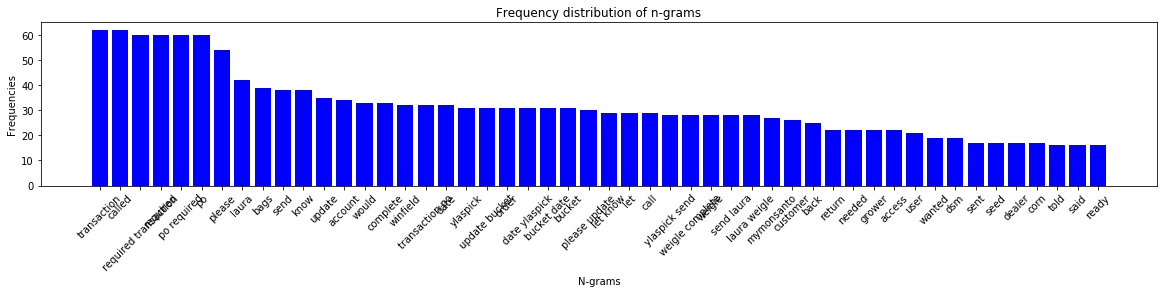

In [17]:
plot_frequency_distribution_of_ngrams(norm_corpus)

# Plot of length distribution of Case Description

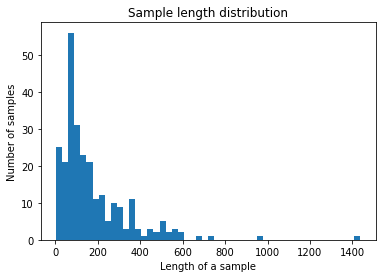

In [18]:
plot_sample_length_distribution(desc_text)

# Plot of Reason code distribution in the Case log

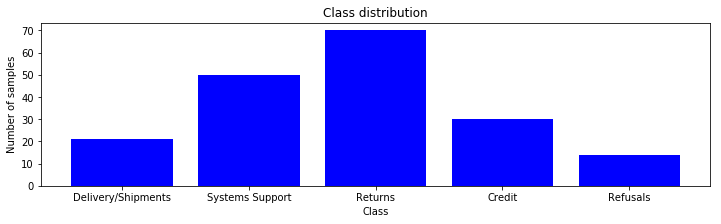

In [19]:
num_classes = 5
count_map = Counter(sfdc_data_filtered['label'])

counts = count_map.values()

[count_map[i] for i in range(num_classes)]
idx = ['Delivery/Shipments','Systems Support','Returns','Credit','Refusals']

plt.figure(figsize=(12, 3))  # width:20, height:3
plt.bar(idx, counts, width=0.8, color='b')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.xticks(idx, idx)
plt.show()

# We use StratifiedShuffleSplit to created train and test samples, and maintain same distribution of Reason codes in train and test set

In [20]:
#Distribution of reason codes in the filtered data
sfdc_data_filtered["label"].value_counts() / len(sfdc_data_filtered)

0    0.378378
1    0.270270
2    0.162162
3    0.113514
4    0.075676
Name: label, dtype: float64

In [21]:
#We use Stratifed Split to maintain the same distribution of Reason codes in Train and Test data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index, test_index in split.split(sfdc_data_filtered,sfdc_data_filtered["label"]):
    strat_train_set = sfdc_data_filtered.iloc[train_index]
    strat_test_set = sfdc_data_filtered.iloc[test_index]

In [22]:
#We see the train set has same distribution of reason codes as in original sample
strat_train_set["label"].value_counts() / len(strat_train_set)

0    0.378378
1    0.270270
2    0.162162
3    0.114865
4    0.074324
Name: label, dtype: float64

In [23]:
#We see the test set has same distribution of reason codes as in original sample
strat_test_set["label"].value_counts() / len(strat_test_set)

0    0.378378
1    0.270270
2    0.162162
3    0.108108
4    0.081081
Name: label, dtype: float64

In [24]:
train_texts=strat_train_set['Case Description'].astype(str)
train_labels=strat_train_set['label'].astype(str)
train_texts=train_texts.reset_index(drop = True)
train_labels=train_labels.reset_index(drop = True)

# We print train and test texts, in the raw form

In [25]:
#We print some sample rows from train data, still the data is not in normalized form
print(train_texts[0])
print(train_labels[0])
print(len(train_texts))
print(train_texts[147])

Getting Login ISA error on this account when he tries to access through My Monsanto. Per Winfield, no issue on the Connect-3 side. Contact dealer for additional info or screenshots.
1
148
Please update bucket date in YLASPICK. Send to Laura Weigle when complete. 5007523318 5007523324 5007523325 5007523326 5007523364 5007523379 5007523390 5007523405 5007523416 5007523417 5007523444 5007523463


In [26]:
test_texts=strat_test_set['Case Description'].astype(str)
test_texts=test_texts.reset_index(drop = True)
test_labels=strat_test_set['label'].astype(str)
test_labels=test_labels.reset_index(drop = True)

In [27]:
print(len(test_texts))
print(test_texts[0])
print(test_labels[0])
print(test_texts[36])
print(test_labels[36])

37
Jamie, How does Winfield United service centers uses printed copies of invoices. and some (maybe) via paper. If your account needs to print paper copies ? can you explain how they use these copies? Does your account scan the invoice copies into their proprietary system and then use a program to complete auto matching to ?clear?? Or are they manually reconciling an invoice to a statement line? Help us understand their process as you know it. Your input will help credit and IT understand the functionality that is needed around printing multiple invoices.
1
Will is having issues accessing C3 to mymonsanto. I emulated Will with no C3 access issues. I will give Will a call.
1


# We normalize the train and test data

In [28]:
norm_train_texts = []
for i in range (len(train_texts)):
    norm_train_texts.append(normalize_text(train_texts[i]))

print(train_texts[15])
print("after normalization")
print(norm_train_texts[15])

44x6; 46x6; 51x8 5007340229 40,990.000 LB PO# required for this transaction 760
after normalization
po required transaction


In [29]:
norm_test_texts = []
for i in range (len(test_texts)):
    norm_test_texts.append(normalize_text(test_texts[i]))

In [30]:
print(test_texts[0])
print("after normalization")
print(norm_test_texts[0])

Jamie, How does Winfield United service centers uses printed copies of invoices. and some (maybe) via paper. If your account needs to print paper copies ? can you explain how they use these copies? Does your account scan the invoice copies into their proprietary system and then use a program to complete auto matching to ?clear?? Or are they manually reconciling an invoice to a statement line? Help us understand their process as you know it. Your input will help credit and IT understand the functionality that is needed around printing multiple invoices.
after normalization
jamie winfield united service centers uses printed copies invoices maybe via paper account needs print paper copies explain use copies account scan invoice copies proprietary system use program complete auto matching clear manually reconciling invoice statement line help us understand process know input help credit understand functionality needed around printing multiple invoices


# We create a Sep CNN network model with final layer with 5 units to predict the reason codes

In [38]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D


def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units = 5
    op_activation = 'softmax'
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

# We create Sequence Vectors from the train data (Case description text)

In [39]:
import tensorflow as tf
import numpy as np

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters

# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index


In [33]:
# Vectorize texts.
x_train, x_test, word_index = sequence_vectorize(norm_train_texts, norm_test_texts)

In [59]:
print(x_train.shape)
print(x_test.shape)
print(norm_train_texts[10])
print(x_train[10])
print(train_labels[10])

(148, 45)
(37, 45)
winfield customer service chelsea bennett user id greenpoint ag blytheville needs access gpos tab winfield businesslink
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  17  35 253 254 255  18  29
 156 157 256  27  15  62  78  17  28]
1


# Train the model and plot validation and train accuracy and loss

In [60]:
learning_rate=1e-3
epochs=10
batch_size=128
blocks=2
filters=64
dropout_rate=0.2
embedding_dim=200
kernel_size=3
pool_size=3
# Create model instance.
# Number of features will be the embedding input dimension. Add 1 for the
# reserved index 0.
num_features = min(len(word_index) + 1, TOP_K)

# Create model instance.
model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

In [61]:
loss = 'sparse_categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 45, 200)           113400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 45, 200)           0         
_________________________________________________________________
separable_conv1d_12 (Separab (None, 45, 64)            13464     
_________________________________________________________________
separable_conv1d_13 (Separab (None, 45, 64)            4352      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
separable_conv1d_14 (Separab (None, 15, 128)           8512      
_________________________________________________________________
separable_conv1d_15 (Separab (None, 15, 128)           16896     
__________

In [55]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

In [63]:
# Train and validate model.
history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
           # callbacks=callbacks,
            validation_data=(x_test, test_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

C:\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 148 samples, validate on 37 samples
Epoch 1/10
 - 1s - loss: 2.4598 - acc: 0.1284 - val_loss: 1.4805 - val_acc: 0.3784
Epoch 2/10
 - 0s - loss: 1.5779 - acc: 0.3311 - val_loss: 1.5005 - val_acc: 0.4595
Epoch 3/10
 - 0s - loss: 1.6435 - acc: 0.2703 - val_loss: 1.4675 - val_acc: 0.3784
Epoch 4/10
 - 0s - loss: 1.4915 - acc: 0.3649 - val_loss: 1.4635 - val_acc: 0.3784
Epoch 5/10
 - 0s - loss: 1.5114 - acc: 0.3581 - val_loss: 1.4848 - val_acc: 0.3784
Epoch 6/10
 - 0s - loss: 1.5053 - acc: 0.3919 - val_loss: 1.4994 - val_acc: 0.3784
Epoch 7/10
 - 0s - loss: 1.4905 - acc: 0.3514 - val_loss: 1.4873 - val_acc: 0.3784
Epoch 8/10
 - 0s - loss: 1.4728 - acc: 0.3311 - val_loss: 1.4618 - val_acc: 0.3784
Epoch 9/10
 - 0s - loss: 1.4821 - acc: 0.3649 - val_loss: 1.4455 - val_acc: 0.3784
Epoch 10/10
 - 0s - loss: 1.4627 - acc: 0.3851 - val_loss: 1.4352 - val_acc: 0.3784


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


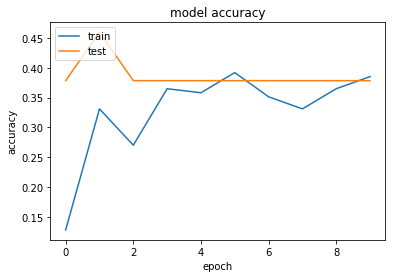

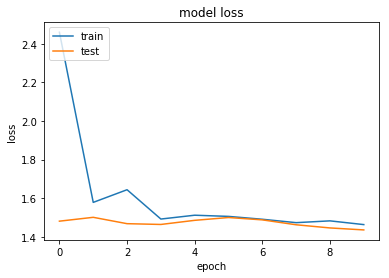

In [64]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
history = history.history
print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

Validation accuracy: 0.37837839126586914, loss: 1.4351856708526611


In [50]:
#Save the model file
#model.save('C:/Users/GCNDP/SentimentAnalysis/sfdc_sepcnn_model.h5')

# Check train accuracy and test accuracy

In [66]:
_, acc = model.evaluate(x_train, train_labels, verbose=0)
print( ' Train Accuracy: %f ' % (acc*100))
_, acc = model.evaluate(x_test, test_labels, verbose=0)
print( ' Test Accuracy: %f ' % (acc*100))

 Train Accuracy: 37.837838 
 Test Accuracy: 37.837838 


In [68]:
from sklearn import metrics
pred = model.predict(x_test)
print(pred[0])
pred_label=np.argmax(pred,axis=1)
print(pred_label[0])
print(metrics.f1_score(test_labels.astype(int), pred_label, average='macro'))

[0.35342246 0.27974275 0.14790197 0.15775844 0.06117438]
0
0.10980392156862744


C:\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
